1. Выберите наборы данных. которые можно интерпретировать, как временные ряды:

а) зависимость цены на недвижимость в еонкретном регионе от времени,

б) скорость полета самолета при перелете из аэропорта А в аэропорт В,

в) количество отказов компьютера,

г) число обращений в поликлинику по району,

д) координаты автобуса при движении по маршруту,

е) координаты фигуры нарушителя в файле видеофиксации охранной системы.


ПРАКТИЧЕСКИ ВСЕ ИЗ СПИСКА МОЖНО ИЗЛОЖИТЬ КАК ВРЕМЕННОЙ РЯД! НЕОБХОДИМО ПРАВИЛЬНО ДОПОЛНИТЬ ПОСТАНОВКУ ЗАДАЧИ. 
Пример:  количество отказов компьютера - один отказ не предсказуем, но количество отказов от начала работы для серии компьютеров, выпущеных на одном заводе в одно время (т.е. партии) вполне описывается (кривая наработки на отказ - временная функция) 


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
import seaborn as sns

import pandas_profiling

from sklearn.metrics import mean_squared_error

Все календари мира :)

In [3]:
import os
os.system("pip install holidays")
import holidays
# календарь праздников Франция за 2019б2020
CF=holidays.FRA(years =[2019,2020])

RF=holidays.RU(years =[2019,2020])
CF,RF

({datetime.date(2019, 1, 1): "Jour de l'an",
  datetime.date(2019, 5, 1): 'Fête du Travail',
  datetime.date(2019, 5, 8): 'Armistice 1945',
  datetime.date(2019, 7, 14): 'Fête nationale',
  datetime.date(2019, 11, 11): 'Armistice 1918',
  datetime.date(2019, 4, 22): 'Lundi de Pâques',
  datetime.date(2019, 6, 10): 'Lundi de Pentecôte',
  datetime.date(2019, 5, 30): 'Ascension',
  datetime.date(2019, 8, 15): 'Assomption',
  datetime.date(2019, 11, 1): 'Toussaint',
  datetime.date(2019, 12, 25): 'Noël',
  datetime.date(2020, 1, 1): "Jour de l'an",
  datetime.date(2020, 5, 1): 'Fête du Travail',
  datetime.date(2020, 5, 8): 'Armistice 1945',
  datetime.date(2020, 7, 14): 'Fête nationale',
  datetime.date(2020, 11, 11): 'Armistice 1918',
  datetime.date(2020, 4, 13): 'Lundi de Pâques',
  datetime.date(2020, 6, 1): 'Lundi de Pentecôte',
  datetime.date(2020, 5, 21): 'Ascension',
  datetime.date(2020, 8, 15): 'Assomption',
  datetime.date(2020, 11, 1): 'Toussaint',
  datetime.date(2020, 12, 

2. Прочитайте DUQ_hourly.csv и проверьте качество и порядок разметки этой выборки с информацией о потреблении энергии в одном из районов Восточной Электросети США. Сделайте описание особенностей этой выборки.


#### Загрузка данных

In [4]:
hourly = pd.read_csv('DUQ_hourly.csv', index_col=[0], parse_dates=[0])

#### Сразу визуализируем ряд

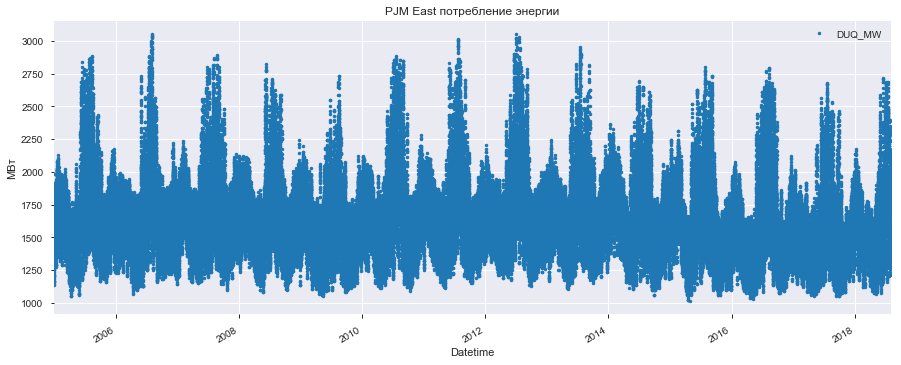

In [5]:
hourly.plot(style='.', figsize=(15, 6), title='PJM East потребление энергии')
plt.ylabel('МВт');

#### Визуальный анализ показывает циклический характер данных.

#### Посмотрим на статистику

In [84]:
pandas_profiling.ProfileReport(hourly)

#### Поскольку данные лежат в диапазоне от 1014МВт до 3054МВт, то очевидно, что точность представления float64 избыточна. Перейдем к целым.

In [6]:
hourly['DUQ_MW'] = hourly['DUQ_MW'].astype('int64')

In [7]:
hourly.head()

,DUQ_MW
Datetime,
2005-12-31 01:00:00,1458
2005-12-31 02:00:00,1377
2005-12-31 03:00:00,1351
2005-12-31 04:00:00,1336
2005-12-31 05:00:00,1356


#### Добавим поле "Дата" для дальнейшей работы

In [8]:
hourly['date'] = hourly.index

In [9]:
# проверим пропуски
hourly['DUQ_MW'].isnull().sum()

0

In [10]:
# проверим задвоения индексов
hourly.index.nunique()

119064

#### Пропусков нет, но есть дни, когда были зафиксированы показания потребления электроэнергии под одним индексом дважды.

In [11]:
hourly.index.value_counts().nlargest()

2017-11-05 02:00:00    2
2014-11-02 02:00:00    2
2015-11-01 02:00:00    2
2016-11-06 02:00:00    2
2007-07-15 10:00:00    1
Name: Datetime, dtype: int64

In [12]:
day_H=hourly['2017-11-01 00:00:00':'2017-11-10 23:00:00'].index.day

In [13]:
day_H.value_counts()

5     25
10    24
9     24
8     24
7     24
6     24
4     24
3     24
2     24
1     24
Name: Datetime, dtype: int64

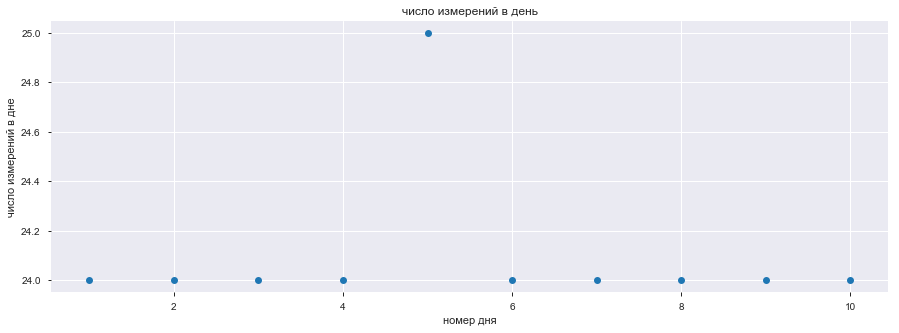

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(day_H.value_counts().index, day_H.value_counts().values ,'o')

plt.xlabel('номер дня')
plt.ylabel('число измерений в дне')
plt.title('число измерений в день')
plt.show()

#### Это может быть связано с переходом на зимнее время. Таким образом, в первое воскресенье ноября продолжительность дня составляет 25 часов, и показания снимаются 25 раз за ден. Наверно будет некорректно удалить одно из показаний под одинаковым индексом, так как сами показания разные, поэтому заменим их на среднее значение.

In [15]:
hourly.head()

,DUQ_MW,date
Datetime,,
2005-12-31 01:00:00,1458,2005-12-31 01:00:00
2005-12-31 02:00:00,1377,2005-12-31 02:00:00
2005-12-31 03:00:00,1351,2005-12-31 03:00:00
2005-12-31 04:00:00,1336,2005-12-31 04:00:00
2005-12-31 05:00:00,1356,2005-12-31 05:00:00


In [95]:
hourly.loc[hourly['date'] == '2017-11-05 02:00:00', 'DUQ_MW'] = hourly.loc[
    hourly['date'] == '2017-11-05 02:00:00', 'DUQ_MW'].mean()

In [96]:
hourly.loc[hourly['date'] == '2014-11-02 02:00:00', 'DUQ_MW'] = hourly.loc[
    hourly['date'] == '2014-11-02 02:00:00', 'DUQ_MW'].mean()

In [97]:
hourly.loc[hourly['date'] == '2015-11-01 02:00:00', 'DUQ_MW'] = hourly.loc[
    hourly['date'] == '2015-11-01 02:00:00', 'DUQ_MW'].mean()

In [98]:
hourly.loc[hourly['date'] == '2016-11-06 02:00:00', 'DUQ_MW'] = hourly.loc[
    hourly['date'] == '2016-11-06 02:00:00', 'DUQ_MW'].mean()

In [99]:
hourly.loc[hourly['date'] == '2007-07-15 10:00:00', 'DUQ_MW'] = hourly.loc[
    hourly['date'] == '2007-07-15 10:00:00', 'DUQ_MW'].mean()

In [100]:
hourly.drop_duplicates(inplace=True)

In [101]:
hourly.shape

(119064, 2)

Удалим задвоения

In [102]:
hourly.drop_duplicates(inplace=True)
hourly.shape

(119064, 2)

#### Найдем дни, когда был переход на летнее время, в эти дни показания потребления электроэнергии будут зафиксированы 23 раза за день.

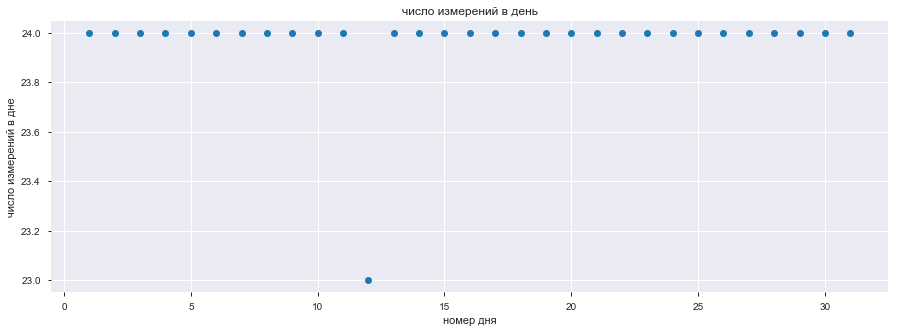

In [103]:
day_H=hourly['2017-03-01 00:00:00':'2017-03-31 23:00:00'].index.day

plt.figure(figsize=(15, 5))
plt.plot(day_H.value_counts().index, day_H.value_counts().values ,'o')

plt.xlabel('номер дня')
plt.ylabel('число измерений в дне')
plt.title('число измерений в день')
plt.show()

In [16]:
Day_count = day_H.value_counts() 
Day_count[Day_count != 24]

5    25
Name: Datetime, dtype: int64

Можно посмотреть иначе. Найдем пропуски по календарю (они есть), как разницу между непрерывной индексацией и индексацией ряда

In [17]:
# непрерывная индексация
full_list_date = pd.date_range(hourly.index.min(), hourly.index.max(), freq="H")
# множество пропусков
diff_list = set(full_list_date) - set(hourly.index.unique())
print(f'Количество пропущенных измерений: {len(diff_list)}')
diff_list

Количество пропущенных измерений: 24


{Timestamp('2005-04-03 03:00:00', freq='H'),
 Timestamp('2005-10-30 02:00:00', freq='H'),
 Timestamp('2006-04-02 03:00:00', freq='H'),
 Timestamp('2006-10-29 02:00:00', freq='H'),
 Timestamp('2007-03-11 03:00:00', freq='H'),
 Timestamp('2007-11-04 02:00:00', freq='H'),
 Timestamp('2008-03-09 03:00:00', freq='H'),
 Timestamp('2008-11-02 02:00:00', freq='H'),
 Timestamp('2009-03-08 03:00:00', freq='H'),
 Timestamp('2009-11-01 02:00:00', freq='H'),
 Timestamp('2010-03-14 03:00:00', freq='H'),
 Timestamp('2010-11-07 02:00:00', freq='H'),
 Timestamp('2010-12-10 00:00:00', freq='H'),
 Timestamp('2011-03-13 03:00:00', freq='H'),
 Timestamp('2011-11-06 02:00:00', freq='H'),
 Timestamp('2012-03-11 03:00:00', freq='H'),
 Timestamp('2012-11-04 02:00:00', freq='H'),
 Timestamp('2013-03-10 03:00:00', freq='H'),
 Timestamp('2013-11-03 02:00:00', freq='H'),
 Timestamp('2014-03-09 03:00:00', freq='H'),
 Timestamp('2015-03-08 03:00:00', freq='H'),
 Timestamp('2016-03-13 03:00:00', freq='H'),
 Timestamp

#### При детальном рассмотрении видим, что, например, 12 марта 2017 года пропущены показания от 3-го часа.

In [106]:
hourly['2017-03-12 01:00:00':'2017-03-12 06:00:00'].index

DatetimeIndex(['2017-03-12 01:00:00', '2017-03-12 02:00:00',
               '2017-03-12 04:00:00', '2017-03-12 05:00:00',
               '2017-03-12 06:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)

#### Найдем дни с 23-ми записями

In [107]:
day_H=hourly['2018-03-01 00:00:00':'2018-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2018 = Day_count[Day_count != 24].index
d2018

Int64Index([11], dtype='int64')

In [108]:
day_H=hourly['2016-03-01 00:00:00':'2016-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2016 = Day_count[Day_count != 24].index
d2016

Int64Index([13], dtype='int64')

In [109]:
day_H=hourly['2015-03-01 00:00:00':'2015-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2015 = Day_count[Day_count != 24].index
d2015

Int64Index([8], dtype='int64')

In [110]:
day_H=hourly['2014-03-01 00:00:00':'2014-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2014 = Day_count[Day_count != 24].index
d2014

Int64Index([9], dtype='int64')

In [111]:
day_H=hourly['2007-03-01 00:00:00':'2007-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2007 = Day_count[Day_count < 24].index
d2007

Int64Index([11], dtype='int64')

In [112]:
day_H=hourly['2008-03-01 00:00:00':'2008-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2008 = Day_count[Day_count < 24].index
d2008

Int64Index([9], dtype='int64')

#### Мы можем добавить пропущенные данные интерполяцией

Поищем проблемы помимо пропусков. Например это 2008/12/10 c 00 до 6 часов - провал потребления (однако , он гладкий, т.е. не очень страшно)

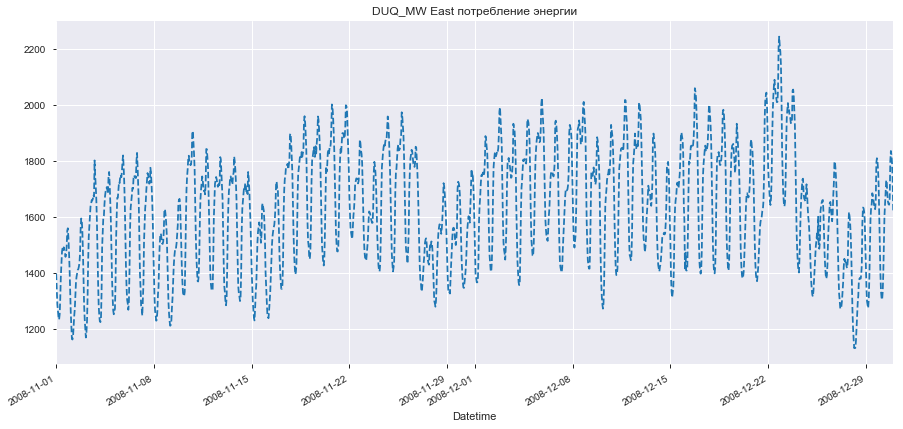

In [113]:
problem1 = hourly['2008-11-01' :'2008-12-30']

_ = problem1['DUQ_MW'].plot( style='--', figsize=( 15, 7 ), title='DUQ_MW East потребление энергии' )

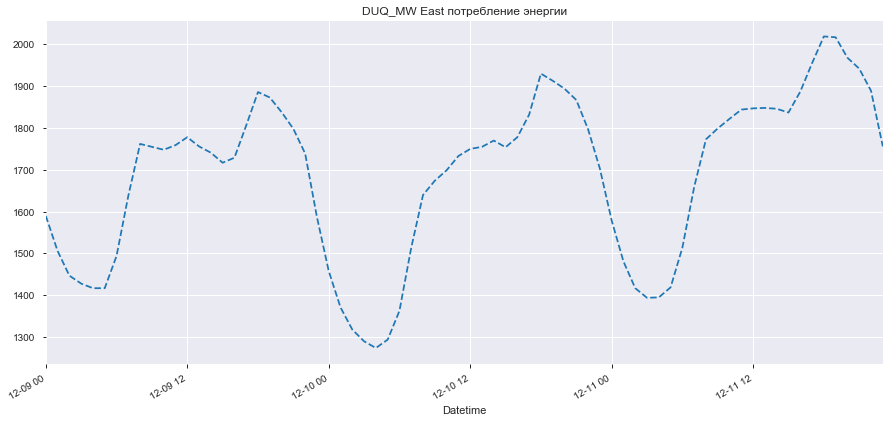

In [114]:
problem1 = hourly['2008-12-09' :'2008-12-11']

_ = problem1['DUQ_MW'].plot( style='--', figsize=( 15, 7 ), title='DUQ_MW East потребление энергии' )

Тут, какой-то провал (требует анализа источника проблемы)

3. Прочитайте базу Brent и сделайте ее перерасчет (ресемплинг) в представление по неделям , по месяцам.

In [115]:
brent = pd.read_excel('нефть-brent 2010-2019.xlsx', index_col=[0], parse_dates=[0])

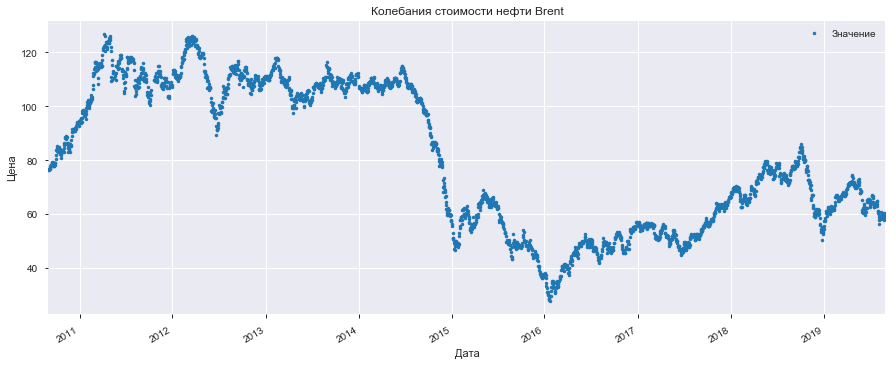

In [116]:
brent.plot(style='.', figsize=(15, 6), title='Колебания стоимости нефти Brent')
plt.ylabel('Цена');

#### Добавим признаков на основе даты и времени

In [117]:
brent['date'] = brent.index

In [118]:
brent.head()

,Значение,date
Дата,,
2019-09-01,58.84,2019-09-01
2019-08-30,59.19,2019-08-30
2019-08-29,60.37,2019-08-29
2019-08-28,59.84,2019-08-28
2019-08-27,59.59,2019-08-27


#### Средние значения стоимости нефти по неделям

In [119]:
brent.resample("W").apply(['mean', 'min', 'max']).head()

Значение              
                 mean    min    max
Дата                               
2010-09-05  76.616000  76.37  76.89
2010-09-12  77.673333  76.87  78.41
2010-09-19  78.693333  77.97  79.20
2010-09-26  78.518333  77.93  79.36
2010-10-03  81.211667  78.14  83.81

#### Средние значения стоимости нефти по месяцам

In [120]:

brent.resample("M").apply(['mean', 'min', 'max']).head()

Значение               
                 mean    min     max
Дата                                
2010-09-30  78.228148  76.37   82.11
2010-10-31  83.473462  80.89   85.30
2010-11-30  86.178077  83.00   89.00
2010-12-31  92.232308  88.92   94.59
2011-01-31  97.033200  93.72  100.56

In [121]:
brent.resample("Y").apply(['mean', 'std']).head()

Значение           
                  mean        std
Дата                             
2010-12-31   84.963238   5.269065
2011-12-31  110.758746   7.021114
2012-12-31  111.377484   7.777702
2013-12-31  108.137114   4.014836
2014-12-31   99.435493  14.512923

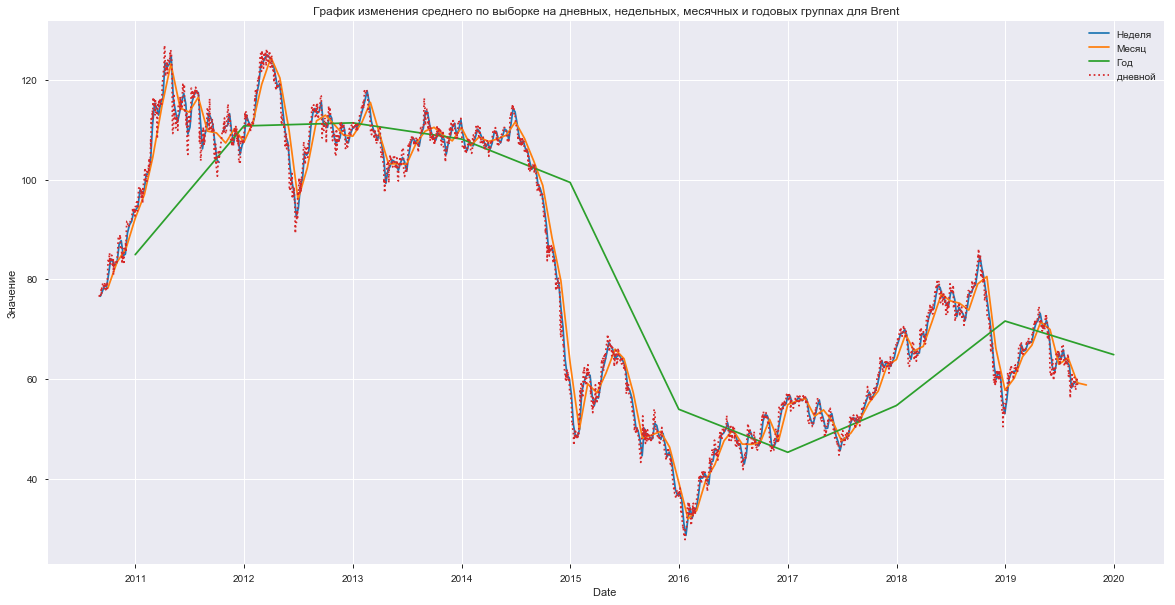

In [122]:
plt.figure(figsize=(20,10))
plt.plot(brent.resample("W").mean().index, brent.resample("W").mean().values)
plt.plot(brent.resample("M").mean().index, brent.resample("M").mean().values)
plt.plot(brent.resample("Y").mean().index, brent.resample("Y").mean().values)
# Для 5го задания
plt.plot(brent.index, brent['Значение'].values, ':')


plt.legend(['Неделя', 'Месяц', 'Год', 'дневной'])

plt.title('График изменения среднего по выборке на дневных, недельных, месячных и годовых группах для Brent')
plt.xlabel('Date ')
plt.ylabel('Значение');

4. Постройте график изменения среднего по выборке и среднего отклонения по выборке на недельных, месячных и годовых группах для Brent.

#### Средняя цена по неделям

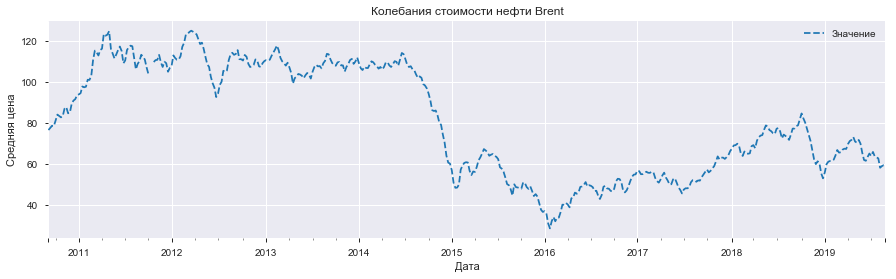

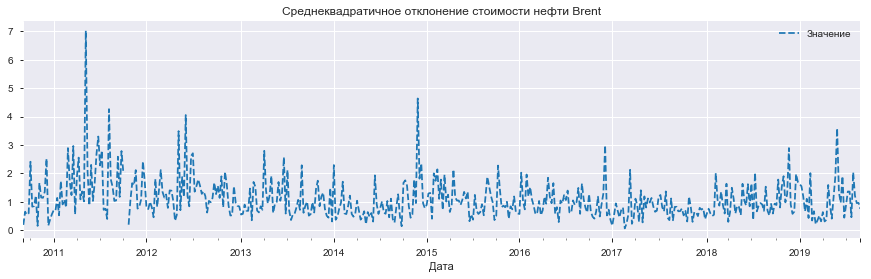

In [123]:

brent.resample("W").mean().plot(style='--', figsize=(15, 4), title='Колебания стоимости нефти Brent')
plt.ylabel('Средняя цена');

brent.resample("W").std().plot(style='--', figsize=(15, 4), title='Среднеквадратичное отклонение стоимости нефти Brent');

#### Средняя цена по месяцам

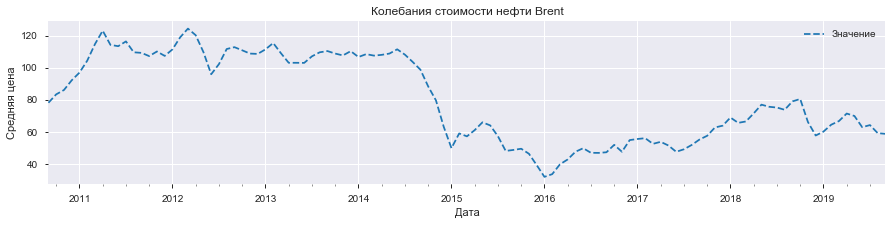

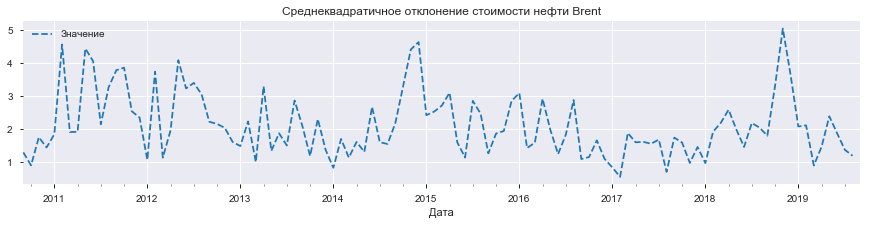

In [124]:
brent.resample("M").mean().plot(style='--', figsize=(15, 3), title='Колебания стоимости нефти Brent')
plt.ylabel('Средняя цена');
brent.resample("M").std().plot( style='--', figsize=(15, 3), title='Среднеквадратичное отклонение стоимости нефти Brent');

#### Среднегодичные цены

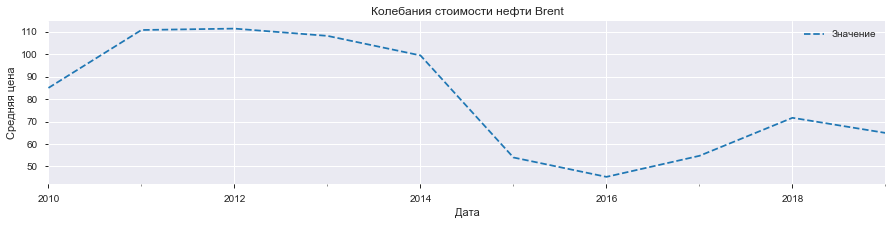

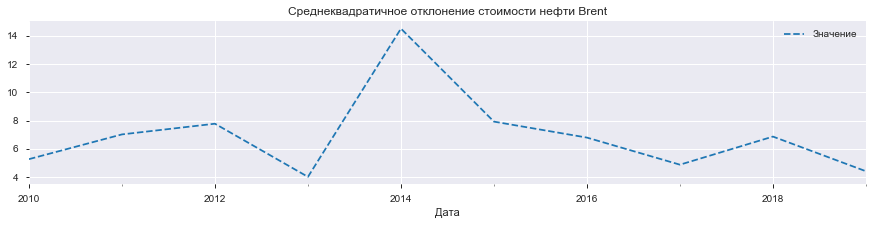

In [125]:
brent.resample("Y").mean().plot(style='--', figsize=(15, 3), title='Колебания стоимости нефти Brent')
plt.ylabel('Средняя цена');
brent.resample("Y").std().plot( style='--', figsize=(15, 3), title='Среднеквадратичное отклонение стоимости нефти Brent');

5. Сделайте вывод о том, как изменилось поведение цены на недельных и месячных графиках по сравнению с дневными.

##### Месячные колебания цены больше недельных, которые, в свою очередь, больше дневных.

Можем поискать проблемы с ценой (изменение уровней в 2015 и 2011 ) их видно на недельном ресемплинге для std - уровень выше чем для всей оставшейся части ряда - резкое изменение цены нефти в течении 1-2 недель (эти проблемы видны и на месячном ресемплинге и на средних по годам).